## Pollen Prediction

Initial approximation of a Deep Learning model for pollen count prediction.

Tested using weather time series data and Gramineae pollen counts from 2019 to 2023 in Madrid.


**Explanation:**

1. **Data Visualization:**
   - Visualizes the input weather conditions and pollen count over time to understand the data trends.

2. **Normalization:**
   - Features are scaled using MinMaxScaler for efficient training.
   - Target (COUNT) is normalized by dividing by the maximum value.

3. **Sequence Creation:**
   - Converts data into sequences of 365 days (annual period) for the LSTM model to learn patterns.

4. **Model:**
   - Uses two LSTM layers followed by a Dense layer for prediction.

5. **Training:**
   - Trains the model on sequences with `loss='mse'` and `metrics=['mae']`.

6. **Evaluation:**
   - Plots the loss and mean absolute error over epochs.
   - Visualizes true vs predicted COUNT for the test data.


#### Author: Javier Villafranca
#### Date: 2025-01-19

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import zipfile

In [3]:
# Load the dataset
# Fields: DATE; Wind_Speed; Temperature; Humidity; Sun_Radiation; Precipitation; Count Gramineae

with zipfile.ZipFile('weather_pollen_series-2019-2023.zip', 'r') as zip_ref:
    # List the files in the ZIP archive
    zip_ref.printdir()

    # Reading CSV file inside the ZIP
    with zip_ref.open('weather_pollen_series-2019-2023.csv') as file:
        columns = ["DATE", "W", "T", "H", "S", "P", "COUNT"]
        data = pd.read_csv(file, sep=";", names=columns, header=0)

# Display the dataframe
print(data.head())

File Name                                             Modified             Size
weather_pollen_series-2019-2023.csv            2025-01-19 18:51:44        67672
         DATE     W    T     H      S    P  COUNT
0  2019-01-01  0.68  6.1  55.0  107.0  0.0      2
1  2019-01-02  0.73  5.4  59.0  108.0  0.0      1
2  2019-01-03  0.84  7.0  50.0  113.0  0.0      0
3  2019-01-04  0.67  5.3  60.0  108.0  0.0      0
4  2019-01-05  0.63  4.8  58.0  110.0  0.0      0


In [4]:
# Load the dataset
# Fields: DATE; Wind_Speed; Temperature; Humidity; Sun_Radiation; Precipitation; Count Gramineae
# Or uncomment the following lines to read plain csv input files

#file_path = "weather_pollen_series-2019-2023.csv"  # Update with the path to your CSV
#columns = ["DATE", "W", "T", "H", "S", "P", "COUNT"]
#data = pd.read_csv(file_path, sep=";", names=columns, header=0)

<Figure size 1200x600 with 0 Axes>

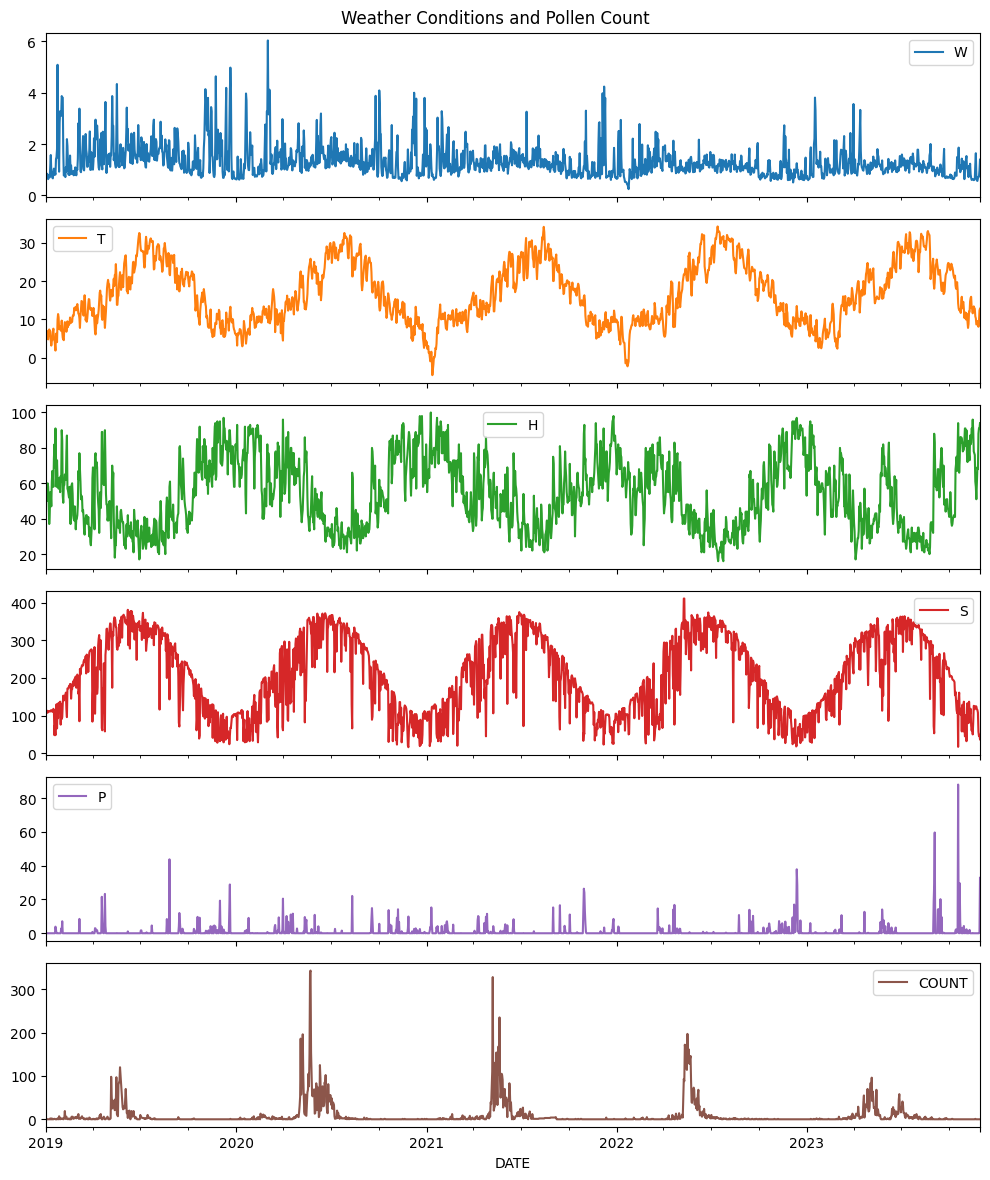

In [5]:
# Convert DATE to datetime
data["DATE"] = pd.to_datetime(data["DATE"])
data.set_index("DATE", inplace=True)

# Visualize the input data
plt.figure(figsize=(12, 6))
data[["W", "T", "H", "S", "P", "COUNT"]].plot(subplots=True, figsize=(10, 12), title="Weather Conditions and Pollen Count")
plt.tight_layout()
plt.show()

In [6]:
# Prepare data for time series prediction
features = ["W", "T", "H", "S", "P"]
target = "COUNT"

# Normalize features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])
data[target] = data[target] / data[target].max()

# Convert data to supervised learning problem
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length, :-1])
        y.append(data[i + sequence_length, -1])
    return np.array(x), np.array(y)

In [7]:
sequence_length = 365  # Annual period

# Combine features and target for sequence creation
data_values = data[features + [target]].values
X, y = create_sequences(data_values, sequence_length)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Define the input layer
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1)
])

I0000 00:00:1737345613.963607    5063 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5797 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1737345618.298800    5165 service.cc:148] XLA service 0x7fcb7c0043a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737345618.299015    5165 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-19 23:00:18.345238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737345618.519626    5165 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-19 23:00:18.595568: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 2/36 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0082 - mae: 0.0706

I0000 00:00:1737345619.263334    5165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0089 - mae: 0.0528 - val_loss: 0.0069 - val_mae: 0.0262
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040 - mae: 0.0331 - val_loss: 0.0057 - val_mae: 0.0299
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038 - mae: 0.0326 - val_loss: 0.0059 - val_mae: 0.0263
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0045 - mae: 0.0308 - val_loss: 0.0052 - val_mae: 0.0332
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031 - mae: 0.0331 - val_loss: 0.0056 - val_mae: 0.0353
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0044 - mae: 0.0350 - val_loss: 0.0050 - val_mae: 0.0253
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0040 - mae: 0.0291 - val_loss: 0.0060 - val_mae: 0.0249
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0035 - mae: 0.0282 - val_loss: 0.0051 - val_mae: 0.0204
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - mae: 0.

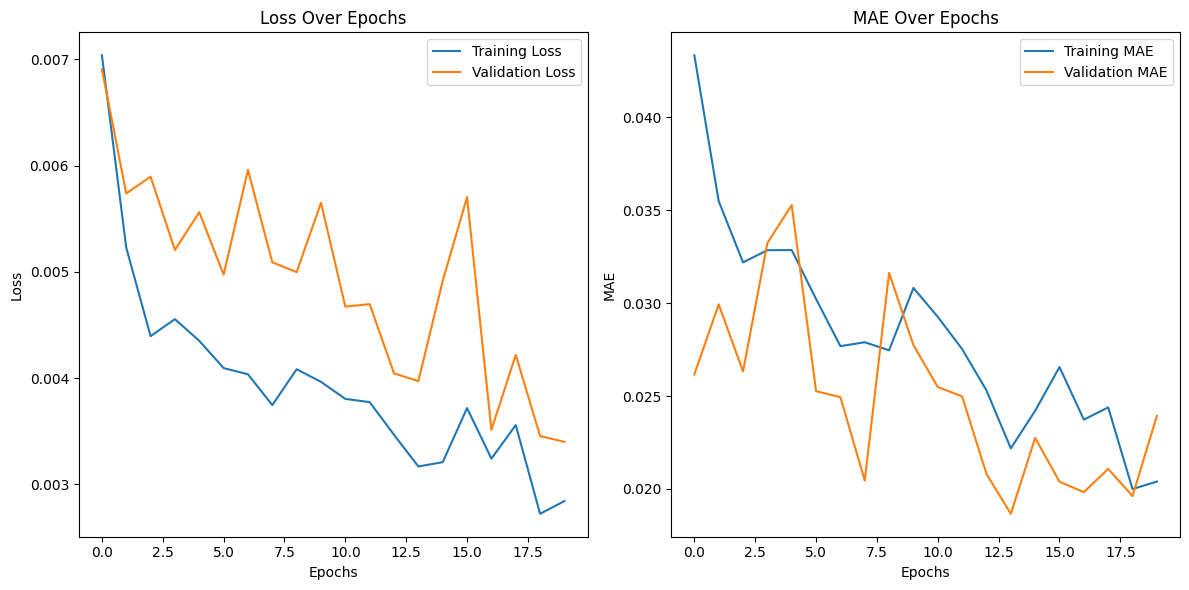

In [11]:
# Plot training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot (using MAE as accuracy proxy)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Predict and evaluate
predictions = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step 


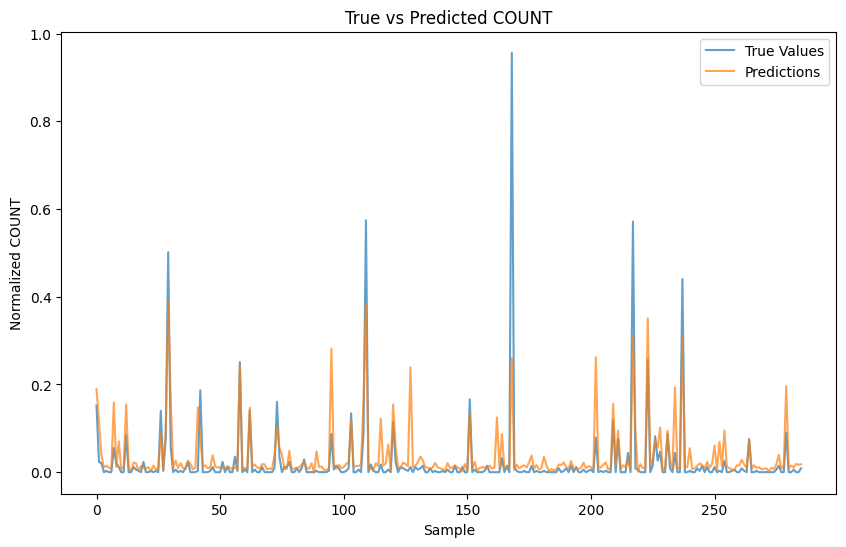

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('True vs Predicted COUNT')
plt.xlabel('Sample')
plt.ylabel('Normalized COUNT')
plt.legend()
plt.show()